# Example 4: Spiral classification
## SI Section 2.6: Spiral classification
### Reference: INN paper https://www.nature.com/articles/s41467-025-63790-8

In this example, we conduct a simple classification task called spiral classification.

Import the pyinn package.

In [1]:
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)
import os, sys

sys.path.insert(0, '../pyinn')
import dataset_classification, train, plot

Set up GPUs (optional)

In [2]:
# gpu_idx = 0
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

Create the spiral dataset.

In [3]:
data_name = 'spiral'
config = {}
config["DATA_PARAM"] = {
    "data_name": data_name,
    "input_col": [0, 1],
    "output_col": [2],
    "nclass": 2,
    "bool_data_generation": True,
    "split_ratio": [0.7, 0.15, 0.15],
    "bool_normalize": True,
    "bool_image": False,
    "bool_shuffle": True
}
config["TRAIN_PARAM"] = {
    "num_epochs_INN": 50,
    "num_epochs_MLP": 100,
    "batch_size": 128,
    "learning_rate": 1e-1,
    "validation_period": 10,
    "patience": 10
}

data = dataset_classification.Data_classification(data_name, config)

Loaded 10000 datapoints from spiral dataset
  Train: 7000, Val: 1500, Test: 1500


Visualize the data.

In [4]:
import pandas as pd

df = pd.read_csv(f'./data/{data_name}.csv')
df.head()

,x1,x2,u
0,1.767685,2.621550,1.0
1,4.567366,1.252164,1.0
2,0.109451,-2.079271,1.0
3,-3.098397,-0.247814,0.0
4,1.018792,-0.206522,0.0


The datafile contains 3 columns: x1, x2, and u. The u denotes the class. Let us plot the data.

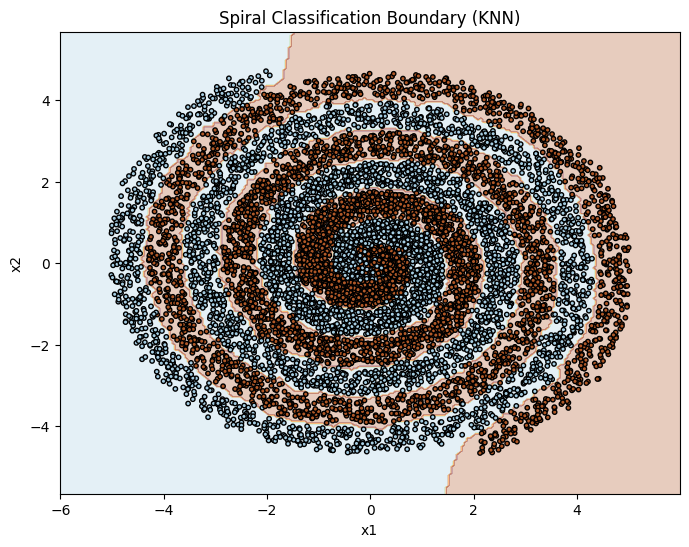

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

X = df[['x1', 'x2']].values
y = df['u'].values

# Train a simple KNN classifier for visualization
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)

# Create mesh grid for decision boundary
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired, s=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Spiral Classification Boundary (KNN)')
plt.show()

Define INN hyperparameters (from Table S7 of SI):
* nmode: 10
* nseg: 20
* s_patch: 2
* INNactivation: polynomial
* p_order: 2

In [6]:
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 2,
    "INNactivation": "polynomial",
    "p_order": 2,
    "radial_basis": "cubicSpline",
    "alpha_dil": 20
}

In [7]:
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear"
else:
    config['interp_method'] = "linear"
config['TD_type'] = "CP"

Train INN classifier

In [8]:
classifier = train.Classification_INN(data, config)
classifier.train()

edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 10: Train loss=9.2139e-02, Val loss=1.2830e-01, Val acc=0.9567
Epoch 20: Train loss=1.1027e-01, Val loss=1.1733e-01, Val acc=0.9593
Epoch 30: Train loss=1.0011e-01, Val loss=1.3685e-01, Val acc=0.9573
Epoch 40: Train loss=1.2932e-01, Val loss=2.3862e-01, Val acc=0.9573
Epoch 50: Train loss=9.7481e-02, Val loss=1.9090e-01, Val acc=0.9560
Training completed in 1.42 seconds
Test accuracy: 0.9600
Inference time: 0.000000 seconds


Plot loss history

Loss plot saved to: plots\spiral_nonlinear_loss_50epoch.png


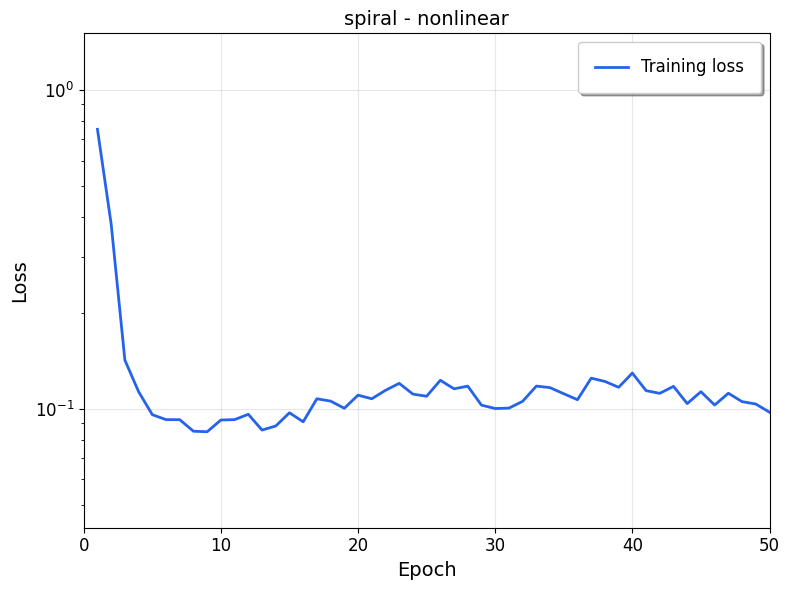

In [9]:
config["PLOT"] = {"bool_plot": True}
plot.plot_classification(classifier, data, config)